# EDA and preprocessing of the scraped data

- In this notebook, we will do some initial exploratory data analysis as well as preprocessing to clean the dataset that from the scraping. 

In [196]:
# Imports
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist, pos_tag
from collections import Counter
import re

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'

## EDA of `job_df.csv` file

- from the previous scraping, we have already eliminated duplicate rows, so I want to first check how many rows the new data frame has after the elimination.
- despite my initial worry, only about 20-25% of data have been dropped, and the dataset is still large enough for us to work with. 
- Also, since descriptions had to be scraped from a separate page through a link, I want to check whether the scraping of the additional page has worked as expected.

In [5]:
jobs_df = pd.read_csv('job_df.csv')

In [6]:
jobs_df.shape

(813, 7)

In [112]:
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813 entries, 0 to 812
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        813 non-null    object
 1   company      813 non-null    object
 2   location     813 non-null    object
 3   summary      813 non-null    object
 4   description  795 non-null    object
 5   salary       813 non-null    object
 6   rating       813 non-null    object
dtypes: object(7)
memory usage: 44.6+ KB


In [28]:
jobs_df['description'].head(5)

0    The Clinical Trial Research Coordinator I (CTRC-I) is a novice level position which, under the clinical direction of the Principal Investigator (PI), assists in the operational and administrative research support of the Kaiser Permanente Northern California (KPNC) PI and KPNC Clinical Trials Operations Director or designee, and other research staff conducting multiple FDA-regulated clinical trials. This is a non-licensed position which works under the daily supervision of an experienced Clinical Trial Nurse, Clinical Trial Research Coordinator, and/or KFRI-designated, licensed clinical trial research staff member. This position must adhere to the position's scope of practice as outlined in the Major Responsibilities below. This position is also responsible for assisting in protecting the health, safety, and welfare of research participants.\n\n\n\nEssential Functions:\nComplianceSupport & comply w/ the Principles of Responsibility (Kaiser Permanente Code of Conduct). W/ guidance f

### Dealing with missing values

- Overall, the scraping was successful although I see about fewer than 20 postings with missing description data.

In [12]:
18/813


0.02214022140221402

- since the number of missing descriptions is 2.2% of the total data, I will drop those values

In [10]:
jobs_df['description'].dropna(inplace=True)

In [206]:
jobs_df[20:30]

,title,company,location,summary,description,salary,rating,desc_length,desc_wordcount,token_desc
20,Data Analyst (Entry) - Data Science - R&D - PH - US_new,Bayer,"Berkeley, CA 94710","Experience with data dashboarding (Spotfire, tableau, or similar).\nWork with users (scientists) to ensure the tools we build are usable and useful.",Perform the following tasks related to the software applications:\nConfiguration\nDevelopment of templates and dashboards\nWork with users (scientists) to ensure the tools we build are usable and useful\nQuickly learn biologics manufacturing process concepts\nEstablish and document best practices\nAnswer user questions\nTroubleshoot problems\nTrain users\nRequired qualification\nUniversity deg...,None,4.2,915,98,perform the following task related to the software application configuration development of template and dashboard work with user scientist to ensure the tool we build are usable and useful quickly learn biologics manufacturing process concept establish and document best practice answer user question troubleshoot problem train user required qualification university degree with 2 year experienc...
21,Payroll Manager_new,Golden Gate Bridge Highway and Transportation District,"San Rafael, CA 94901 (Canal area)","Maintain control of payroll system; conduct regular system and process audits to ensure data integrity and compliance.\nPosition is located in San Rafael, CA.","POSITION: PAYROLL MANAGER (PS101503)Position is located in San Rafael, CA.SALARY RANGE: $102,252.80 to $123,593.60 annually plus excellent benefits 40-hour workweekEmployee pays 7% of salary/wage toward CalPERS retirement plan DATEPOSITION DESCRIPTION:Under general direction of the Director of Accounting along with collaboration with the Managers of Human Resources, Deputy General Manager-Admi...","$102,252 - $123,593 a year",None,10011,1253,position payroll manager ps101503 position is located in san rafael ca salary range 102 252 80 to 123 593 60 annually plus excellent benefit 40 hour workweekemployee pay 7 of salary wage toward calpers retirement plan dateposition description under general direction of the director of accounting along with collaboration with the manager of human resource deputy general manager administrative a...
22,"Program Manager, Business Operations, Data Centers_new",Google,"San Francisco, CA","Bachelor's degree in Technology, Engineering, Science, Economics, Business or related field or equivalent practical experience.","Note: By applying to this position your application is automatically submitted to the following locations: San Francisco, CA, USA; Sunnyvale, CA, USA\nMinimum qualifications:\n\nBachelor's degree in Technology, Engineering, Science, Economics, Business or related field or equivalent practical experience.\n1-year of experience in project or program management.\nExperience creating dashboards (L...",None,4.3,2300,295,note by applying to this position your application is automatically submitted to the following location san francisco ca usa sunnyvale ca usa minimum qualification bachelor s degree in technology engineering science economics business or related field or equivalent practical experience 1 year of experience in project or program management experience creating dashboard looker tableau data studi...
23,Contracts Administrator_new,Banking and Finance Professionals,"Foster City, CA 94404",Ø Conduct analysis and maintain database systems related to contracts and proposals.\nØ Perform data integrity and quality control checks to identify areas of…,"Ø Conduct analysis and maintain database systems related to contracts and proposalsØ Execute and distribute various reports presenting statistics to departmental management to keep them advised on the status, volume of contracts being executed or amended.Ø Provide internal stakeholders with tracking reports, memos and other ad hoc reports in a timely manner.Ø Perform data integrity and quality...",$50 - $60 an hour,None,2133,280,ø conduct

In [31]:
jobs_df['company'].nunique()

526

In [32]:
jobs_df['company'].value_counts(sort=True)

University of California San Francisco    15
Oracle                                    11
Amazon Web Services, Inc.                 10
Salesforce                                 9
First Republic Bank                        8
                                          ..
Entegee                                    1
Profloors                                  1
Advance Auto Parts                         1
Frontapp                                   1
Marie Veronique                            1
Name: company, Length: 526, dtype: int64

In [33]:
jobs_df['title'].nunique()

759

In [44]:
jobs_df['title'].value_counts(sort=True)

Data Engineer                                     14
Software Engineer                                  4
Data Analyst                                       4
Data Engineer_new                                  3
Data Manager                                       3
                                                  ..
Medical Director_new                               1
Parent Educator                                    1
Program Manager, Supply Planning, Data Centers     1
Database Consultant                                1
Data Engineering Lead : 21-00481                   1
Name: title, Length: 759, dtype: int64

### Dealing with missing/messy values

- Although `.info()` seem to indicate that 'salary' data is present, I know from browsing the websites that most positions do not post salary with the job. So I took a closer look.
- Most likely, I will still keep this column as 'additional information available' but won't use the actual values for modeling. 
- The values range greatly within the position, and the salary data is in both yearly and hourly rates. At the end, we know that the total compensation will change a lot, so I decided not to incorporate this data. 

In [110]:
jobs_df['salary'].sort_values(ascending=True)[:50]

89     $100,000 - $120,000 a year
290    $100,483 - $122,813 a year
21     $102,252 - $123,593 a year
326    $103,759 - $126,816 a year
132    $105,144 - $127,790 a year
211    $107,000 - $137,813 a year
285    $110,000 - $177,290 a year
448    $112,488 - $136,740 a year
144    $114,000 - $124,000 a year
229    $115,700 - $191,000 a year
417    $120,000 - $160,000 a year
775    $120,000 - $160,000 a year
690    $126,816 - $149,874 a year
297    $126,816 - $149,874 a year
548    $130,000 - $135,000 a year
787    $130,000 - $150,000 a year
767    $130,000 - $150,000 a year
739    $140,000 - $160,000 a year
172    $140,000 - $200,000 a year
705               $140,000 a year
803       $15.39 - $16.39 an hour
108    $150,000 - $170,000 a year
239             $16 - $17 an hour
742    $160,000 - $185,000 a year
807             $17 - $18 an hour
800             $17 - $20 an hour
127                   $17 an hour
646             $18 - $23 an hour
220             $18 - $30 an hour
48        $18.

In [37]:
jobs_df.value_counts(jobs_df['rating'] == 'None')

rating
False    559
True     254
dtype: int64

In [40]:
jobs_df_norating = jobs_df[jobs_df['rating'] == 'None']
jobs_df_rating = jobs_df[jobs_df['rating'] != 'None']

In [42]:
print(jobs_df_norating.shape)
print(jobs_df_rating.shape)

(254, 10)
(559, 10)


In [49]:
jobs_df_rating['rating'] = jobs_df_rating['rating'].astype(float)

<ipython-input-49-1a698d1191de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_df_rating['rating'] = jobs_df_rating['rating'].astype(float)


<AxesSubplot:xlabel='rating', ylabel='Count'>

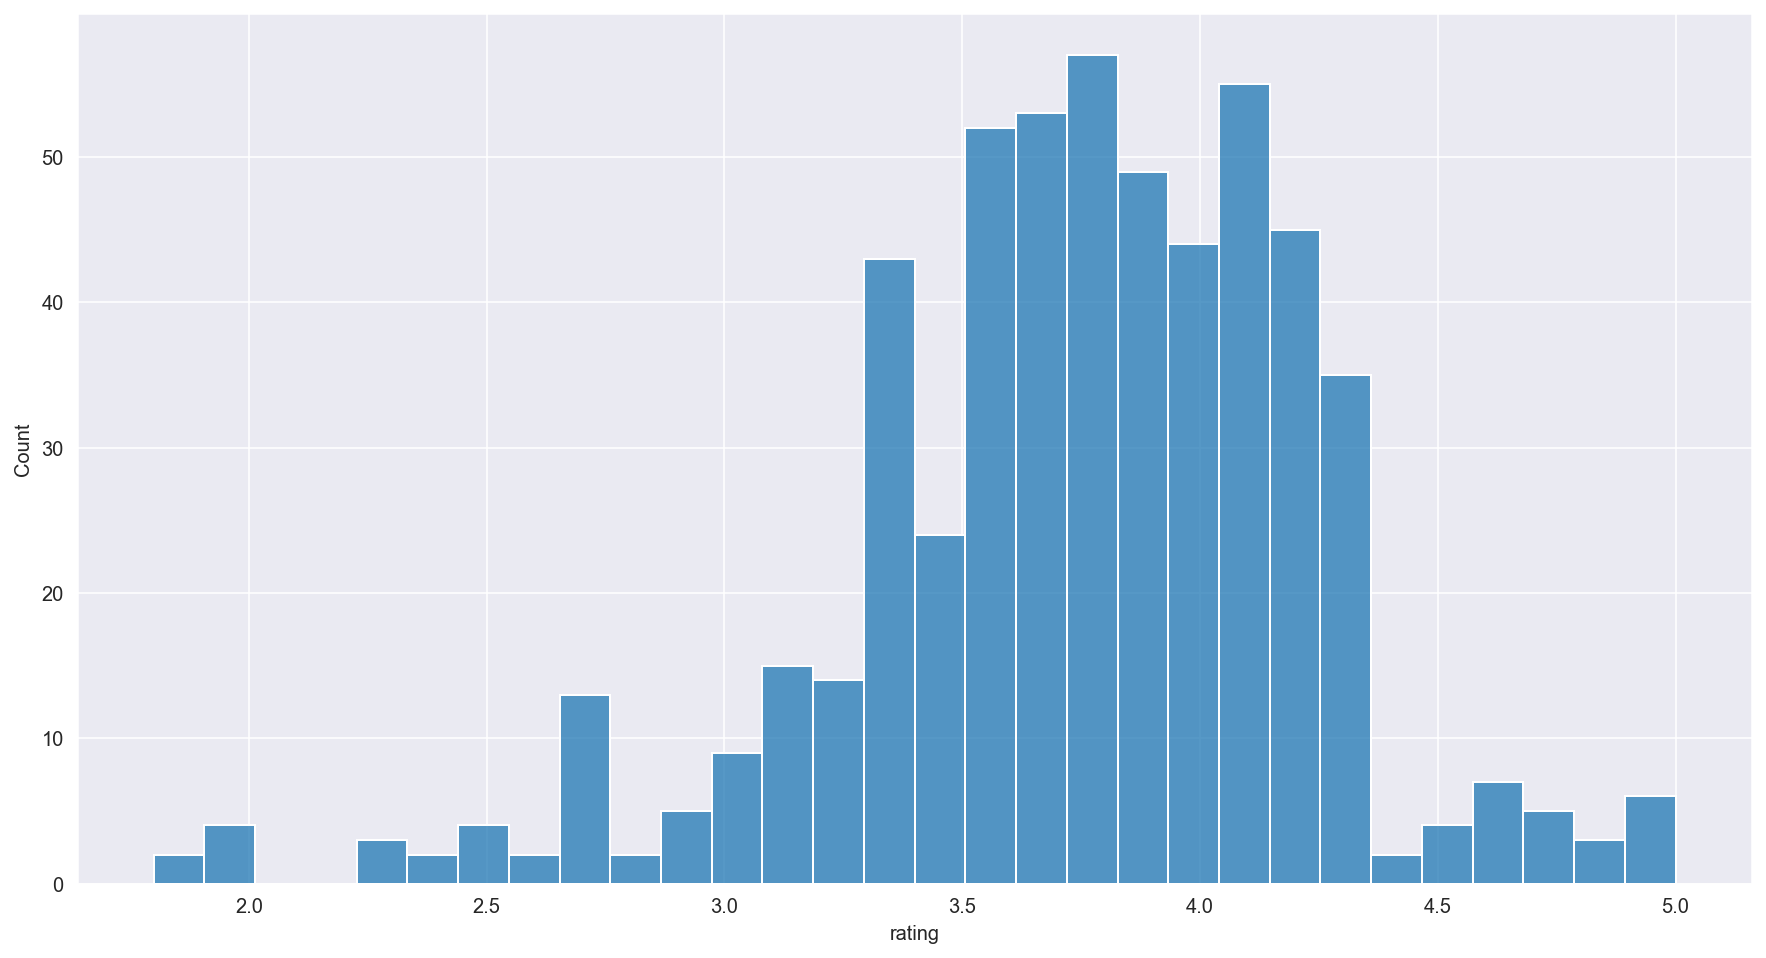

In [60]:
plt.figure(figsize=(15,8))
sns.histplot(jobs_df_rating['rating'], bins=30)

In [61]:
jobs_df_rating['rating'].mean()

3.7545617173524106

In [62]:
jobs_df_rating['rating'].median()

3.8

In [63]:
jobs_df_rating.to_csv('jobs_df_rating.csv', index=False)

In [64]:
jobs_df_norating.to_csv('jobs_df_norating.csv', index=False)

### Dealing with uniquely large columns

- Just by looking at the first few entries, we can see that job descriptions are very long. 
- I wanted to know whether these entries are some few exceptions or the norm.

In [19]:
jobs_df['desc_wordcount'] = jobs_df['description'].apply(lambda x: len(str(x).split(" ")))

<AxesSubplot:xlabel='desc_wordcount', ylabel='Count'>

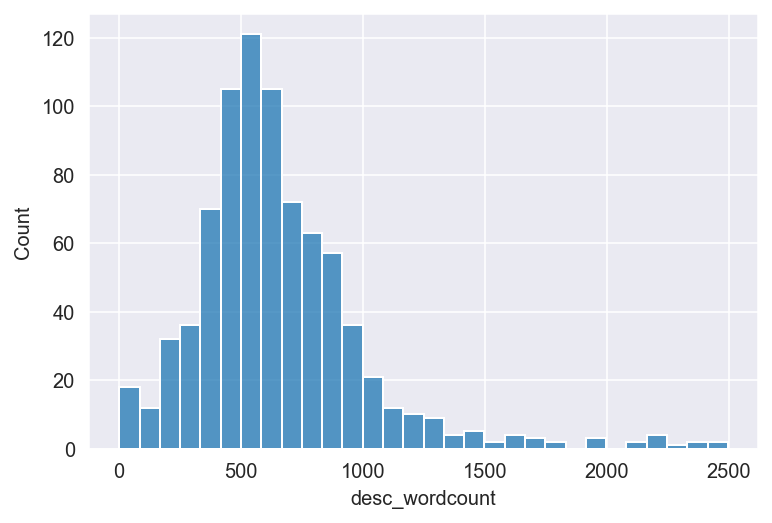

In [18]:
sns.histplot(jobs_df['desc_wordcount'], bins=30)

In [201]:
jobs_df['desc_wordcount'].mean() 

651.50061500615

## Training datasets from Glassdoor

In [65]:
dataanalyst = pd.read_csv('DataAnalyst.csv', index_col=0)
dataengineer = pd.read_csv('DataEngineer.csv', index_col=0)
datascientist = pd.read_csv('DataScientist.csv', index_col=0)
businessanalyst = pd.read_csv('BusinessAnalyst.csv', index_col=0)

In [138]:
data_glassdoor = pd.concat([dataanalyst, dataengineer, datascientist, businessanalyst])

In [86]:
data_glassdoor.head()

Salary Estimate  \
Data Analyst, Center on Immigration and Justice (CIJ)                 $37K-$66K (Glassdoor est.)   
Quality Data Analyst                                                  $37K-$66K (Glassdoor est.)   
Senior Data Analyst, Insights & Analytics Team [Customer Operations]  $37K-$66K (Glassdoor est.)   
Data Analyst                                                          $37K-$66K (Glassdoor est.)   
Reporting Data Analyst                                                $37K-$66K (Glassdoor est.)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [87]:
data_glassdoor.shape

(16160, 16)

In [151]:
data_glassdoor = pd.read_csv('data_glassdoor.csv')

In [139]:
data_glassdoor['title']=data_glassdoor.index
data_glassdoor = data_glassdoor.reset_index(drop=True)

In [83]:
data_glassdoor = data_glassdoor[['Salary Estimate', 'Job Description', 'Rating', 'Company Name', 'title']]

In [147]:
data_glassdoor.columns = ['salary', 'rating', ]

In [146]:
data_glassdoor['salary_min'],data_glassdoor['salary_max']=data_glassdoor['salary'].str.split('-').str
data_glassdoor['salary_min']=data_glassdoor['salary_min'].str.strip(' ').str.lstrip('$').str.rstrip('K').fillna(0)
data_glassdoor['salary_max']=data_glassdoor['salary_max'].str.strip(' ').str.lstrip('$').str.rstrip('K').fillna(0)

In [143]:
data_glassdoor.head()

,salary_min,salary_max,rating,company,title
0,37000.0,66000,3.2,Vera Institute of Justice\n3.2,"Data Analyst, Center on Immigration and Justice (CIJ)"
1,37000.0,66000,3.8,Visiting Nurse Service of New York\n3.8,Quality Data Analyst
2,37000.0,66000,3.4,Squarespace\n3.4,"Senior Data Analyst, Insights & Analytics Team [Customer Operations]"
3,37000.0,66000,4.1,Celerity\n4.1,Data Analyst
4,37000.0,66000,3.9,FanDuel\n3.9,Reporting Data Analyst


In [152]:
data_glassdoor['company'], _ = data_glassdoor['company'].str.split('\n', 1).str

<ipython-input-152-bdab571219a4>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  data_glassdoor['company'], _ = data_glassdoor['company'].str.split('\n', 1).str


In [175]:

data_glassdoor.head()

salary_min salary_max  \
0     37000.0      66000   
1     37000.0      66000   
2     37000.0      66000   
3     37000.0      66000   
4     37000.0      66000   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [174]:
data_glassdoor = pd.read_csv('data_glassdoor.csv')

In [189]:
data_glassdoor.to_csv('data_glassdoor.csv', index=False)

In [176]:
data_glassdoor['salary_max'] = pd.to_numeric(data_glassdoor['salary_max'], errors='coerce')

In [177]:

data_glassdoor['salary_max'].isnull().sum()

627

In [181]:
data_glassdoor.dropna(inplace=True)

In [182]:
data_glassdoor['salary_max'].isnull().sum()

0

In [183]:
data_glassdoor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15447 entries, 0 to 15749
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   salary_min   15447 non-null  float64
 1   salary_max   15447 non-null  float64
 2   description  15447 non-null  object 
 3   rating       15447 non-null  object 
 4   company      15447 non-null  object 
 5   title        15447 non-null  object 
dtypes: float64(2), object(4)
memory usage: 1.4+ MB


In [186]:
data_glassdoor['salary_avg'] = (data_glassdoor['salary_max']+data_glassdoor['salary_min'])/2 

In [198]:
data_glassdoor['salary_max'].mean()

108525.15051466304

In [199]:
data_glassdoor['salary_min'].mean()

64937.01042273581

In [200]:
data_glassdoor['salary_avg'].mean()

86731.08046869942

/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

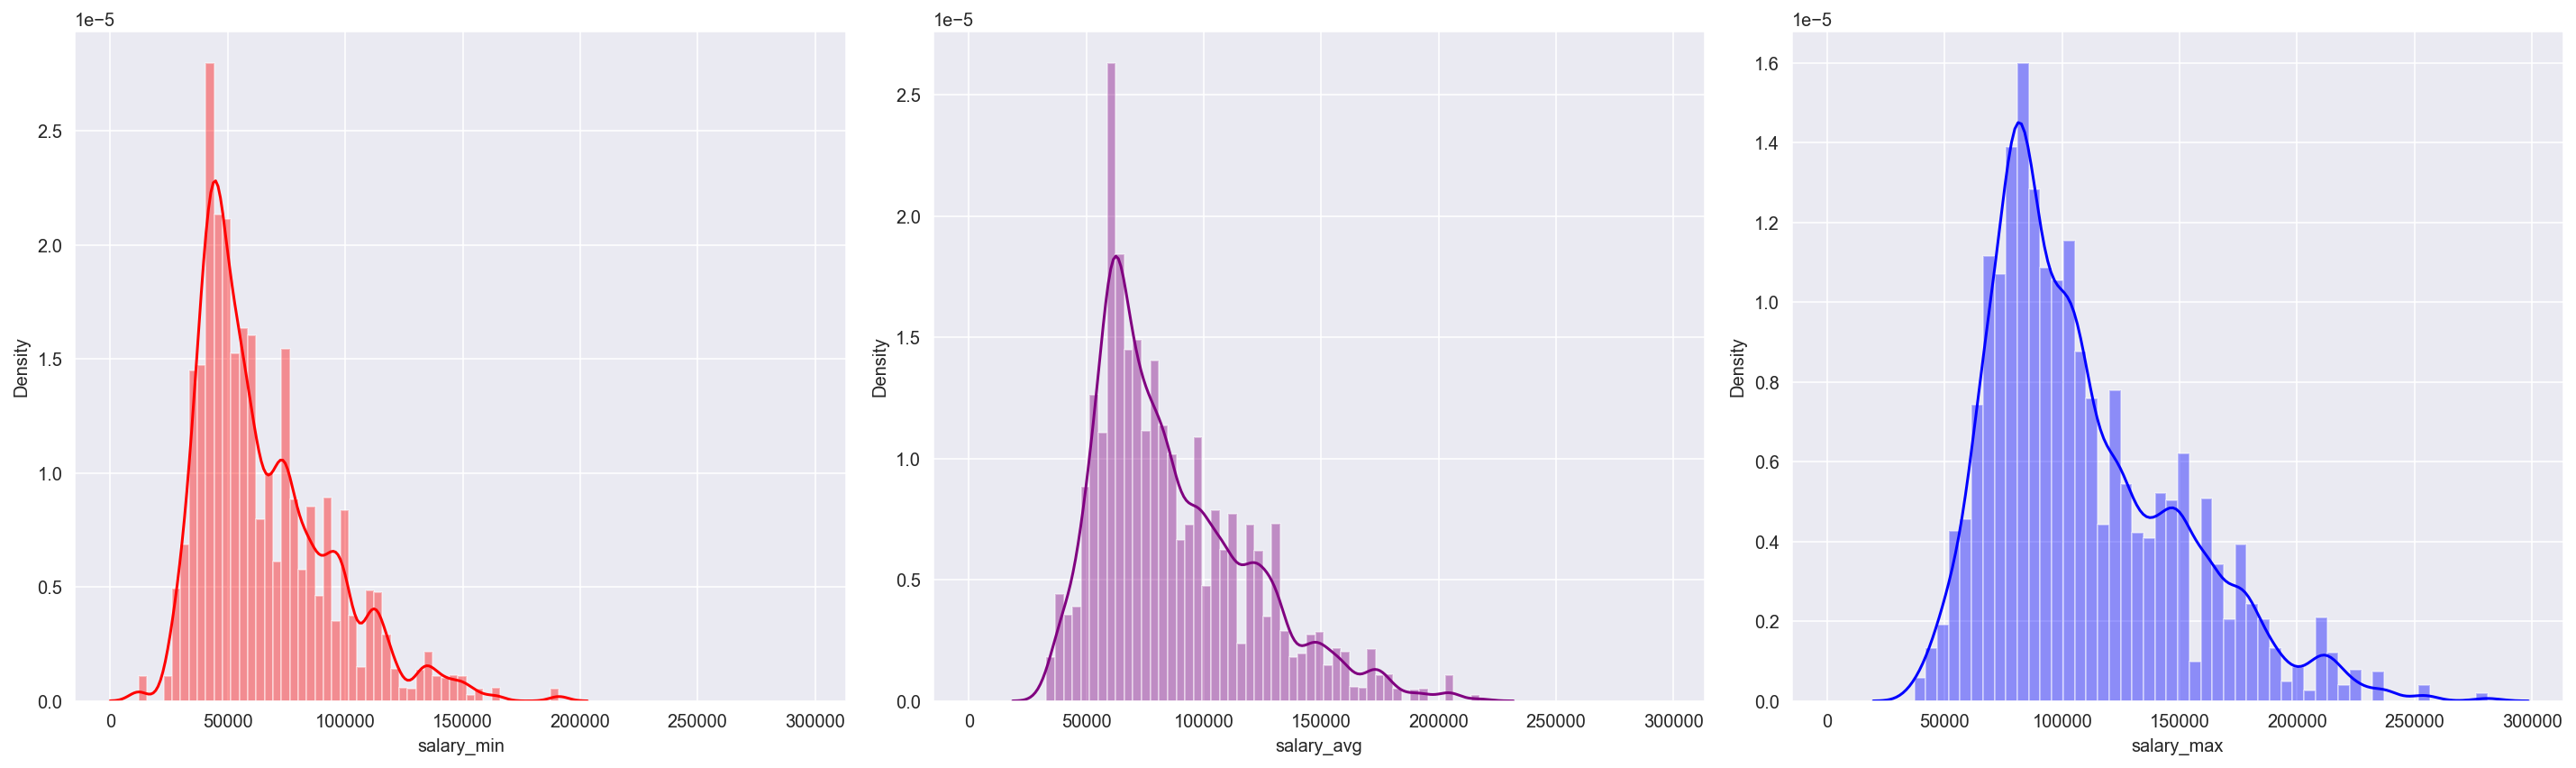

In [188]:

f, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)


#Plot a histogram and kernel density estimate

sns.distplot(data_glassdoor['salary_min'], color="red", ax=axes[0])
sns.distplot(data_glassdoor['salary_avg'], color="purple", ax=axes[1])

sns.distplot(data_glassdoor['salary_max'], color="blue",ax=axes[2])


plt.tight_layout()

In [190]:
def classify_rating(num):
    if float(num) < 3.5:
        return 'below average'
    elif float(num) > 4:
        return 'above average'
    else:
        return 'average'


data_glassdoor['rating_class'] = data_glassdoor['rating'].apply(lambda x: classify_rating(x))

In [191]:
data_glassdoor.head()

salary_min  salary_max  \
0     37000.0     66000.0   
1     37000.0     66000.0   
2     37000.0     66000.0   
3     37000.0     66000.0   
4     37000.0     66000.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

## Preprocessing [job_description] column
### Tokenize and lemmatize job descriptions

In [23]:
# function to tokenize and lemmatize the job description

    
def tokenlem(desc):
    desc = str(desc)
    desc.replace('\n', "")
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    
    tokens = [token.lower() for token in tokenizer.tokenize(desc)]
   
    out = []
    for token in tokens:
        lem = lemmatizer.lemmatize(token)
        out.append(lem)
        if token != lem:
            print(token, lem)
    return ' '.join(out)

# after processing the title, join the words together back to string to be processed for CountVectorizer
   

In [24]:
jobs_df['token_desc'] = jobs_df['description'].apply(lambda x: tokenlem(x))

assists assist
trials trial
operations operation
trials trial
works work
as a
responsibilities responsibility
participants participant
functions function
principles principle
procedures procedure
applications application
regulations regulation
policies policy
procedures procedure
inspections inspection
audits audit
visits visit
participants participant
forms form
participants participant
assessments assessment
visits visit
tests test
kits kit
packets packet
participants participant
instructions instruction
numbers number
calendars calendar
diaries diary
records record
results result
projects project
participants participant
specimens specimen
regulations regulation
guidelines guideline
issues issue
documents document
submissions submission
as a
submissions submission
consents consent
charts chart
files file
supplies supply
dates date
documents document
mds md
rns rn
licenses license
cvs cv
violations violation
deviations deviation
documents document
activities activity
files file
quali

women woman
details detail
opportunities opportunity
persons person
disabilities disability
observances observance
functions function
accommodations accommodation
accommodations accommodation
opportunities opportunity
needs need
us u
us u
statements statement
candidates candidate
candidates candidate
records record
as a
employees employee
applicants applicant
employees employee
employees employee
applicants applicant
as a
functions function
employees employee
applicants applicant
individuals individual
benefits benefit
providers provider
principles principle
practices practice
results result
coordinates coordinate
components component
devices device
trainings training
searches search
timelines timeline
supports support
learners learner
materials material
persons person
disabilities disability
conducts conduct
reviews review
uses us
tools tool
technologies technology
materials material
modules module
operations operation
deliverables deliverable
databases database
applications applicati

techniques technique
systems system
products product
responsibilities responsibility
methods method
sources source
procedures procedure
systems system
features feature
classifiers classifier
techniques technique
results result
systems system
its it
skills skill
qualifications qualification
skills skill
tools tool
as a
languages language
as a
databases database
as a
lakes lake
skills skill
diseases disease
programs program
diseases disease
humans human
diseases disease
diseases disease
assists assist
duties duty
duties duty
pathogens pathogen
outbreaks outbreak
centers center
shipments shipment
duties duty
associates associate
reagents reagent
media medium
as a
as a
assists assist
tasks task
duties duty
reagents reagent
disposables disposable
buffers buffer
media medium
hours hour
references reference
functions function
pathogens pathogen
strains strain
spreadsheets spreadsheet
media medium
reagents reagent
reagents reagent
disposables disposable
duties duty
as a
qualifications qualific

technologies technology
operations operation
partners partner
goals goal
opportunities opportunity
campaigns campaign
sales sale
responsibilities responsibility
sales sale
engagements engagement
programs program
teams team
stories story
propositions proposition
sales sale
partners partner
dashboards dashboard
investments investment
stakeholders stakeholder
relationships relationship
champions champion
organizations organization
sales sale
teams team
plans plan
partners partner
goals goal
challenges challenge
priorities priority
propositions proposition
initiatives initiative
opportunities opportunity
requirements requirement
integrations integration
years year
sales sale
partnerships partnership
sales sale
plans plan
models model
skills skill
relationships relationship
skills skill
goals goal
benefits benefit
dependents dependent
resources resource
options option
grants grant
individuals individual
regards regard
conditions condition
beliefs belief
practices practice
laws law
services 

employees employee
as a
duties duty
monitors monitor
meets meet
benefits benefit
requirements requirement
works work
resources resource
monitors monitor
employees employee
substitutes substitute
employees employee
hours hour
shifts shift
schedules schedule
employees employee
records record
purposes purpose
inputs input
employees employee
absences absence
deductions deduction
answers answer
inquiries inquiry
employees employee
recruits recruit
sets set
interviews interview
holds hold
meetings meeting
substitutes substitute
processes process
substitutes substitute
works work
resources resource
recruits recruit
sets set
interviews interview
holds hold
meetings meeting
employees employee
processes process
employees employee
employees employee
hours hour
postings posting
communications communication
employees employee
actions action
resources resource
puts put
packets packet
resources resource
schedules schedule
sets set
interviews interview
works work
cities city
minors minor
works work
vo

its it
was wa
brands brand
its it
features feature
products product
tools tool
consultations consultation
classes class
advisors advisor
its it
media medium
states state
services service
services service
as a
as a
users user
its it
teams team
values value
customers customer
americas america
processes process
practices practice
industries industry
tools tool
responsibilities responsibility
relationships relationship
solutions solution
aspects aspect
clients client
operations operation
processes process
solutions solution
resources resource
developers developer
clients client
requirements requirement
clients client
managers manager
sales sale
implementations implementation
processes process
sales sale
skills skill
masters master
systems system
years year
languages language
tools tool
hours hour
processes process
responsibilities responsibility
industries industry
users user
responsibilities responsibility
challenges challenge
challenges challenge
opportunities opportunity
technologies te

times time
tools tool
responsibilities responsibility
engineers engineer
technicians technician
goals goal
projects project
schedules schedule
requirements requirement
specifications specification
issues issue
reports report
solutions solution
metrics metric
goals goal
requirements requirement
specifications specification
activities activity
requirements requirement
requirements requirement
years year
years year
as a
skills skill
skills skill
procedures procedure
relationships relationship
circles circle
as a
as a
manufacturers manufacturer
platforms platform
as a
fixtures fixture
devices device
systems system
methodologies methodology
requirements requirement
responsibilities responsibility
procedures procedure
processes process
as a
requirements requirement
documents document
requirements requirement
times time
assists assist
trials trial
operations operation
trials trial
works work
as a
responsibilities responsibility
participants participant
functions function
principles principle


assessments assessment
risks risk
applications application
systems system
vendors vendor
parties party
teams team
controls control
relationships relationship
architects architect
teams team
partners partner
efforts effort
tools tool
as a
as a
tools tool
services service
owners owner
partners partner
methodologies methodology
trends trend
technologies technology
systems system
operations operation
teams team
teams team
partners partner
teams team
plans plan
actions action
programs program
as a
as a
technologies technology
systems system
methodologies methodology
teams team
goals goal
years year
systems system
environments environment
tools tool
ids id
ips ip
firewalls firewall
abilities ability
skills skill
as a
as a
skills skill
audiences audience
standards standard
as a
certifications certification
persons person
services service
employees employee
us u
applicants applicant
covers cover
practices practice
applicants applicant
positions position
categories category
categories category


hours hour
snacks snack
considerations consideration
employees employee
as a
as a
barriers barrier
masks mask
gloves glove
employees employee
contributions contribution
https http
conditions condition
employees employee
guidelines guideline
procedures procedure
ebs eb
months month
ebs eb
things thing
as a
solutions solution
ebs eb
acts act
as a
vendors vendor
solutions solution
policies policy
requirements requirement
years year
as a
ebs eb
ebs eb
ebs eb
ebs eb
upgrades upgrade
upgrades upgrade
upgrades upgrade
ebs eb
utilities utility
ebs eb
issues issue
locks lock
accounts account
databases database
scripts script
technologies technology
iaas iaa
interfaces interface
solutions solution
recommendations recommendation
holdings holding
words word
has ha
channels channel
retailers retailer
collaborations collaboration
acquisitions acquisition
brands brand
partnerships partnership
shows show
ways way
things thing
words word
stories story
brands brand
jacobs jacob
as a
brands brand
hands h

members member
skills skill
skills skill
takes take
guidelines guideline
employees employee
operations operation
responsibilities responsibility
sales sale
operations operation
sales sale
operations operation
requirements requirement
requirements requirement
pandas panda
benefits benefit
pays pay
pays pay
benefits benefit
schedules schedule
holidays holiday
days day
hands hand
systems system
individuals individual
fundamentals fundamental
responsibilities responsibility
processes process
centers center
partners partner
platforms platform
tools tool
insights insight
customers customer
customers customer
consumers consumer
systems system
components component
engineers engineer
requirements requirement
sales sale
teams team
features feature
us u
clients client
issues issue
requirements requirement
hands hand
pipelines pipeline
technologies technology
years year
databases database
processes process
technologies technology
systems system
statistics statistic
algorithms algorithm
algorithms 

expressions expression
orientations orientation
religions religion
ethnicities ethnicity
ages age
citizenships citizenship
statuses status
disabilities disability
statuses status
hours hour
hours hour
graduates graduate
majors major
disciplines discipline
sciences science
interns intern
borders border
candidates candidate
changes change
candidates candidate
us u
us u
operations operation
operations operation
operations operation
medicines medicine
patients patient
costs cost
samples sample
samples sample
responsibilities responsibility
tools tool
groups group
solutions solution
members member
functions function
processes process
projects project
metrics metric
reports report
analyses analysis
solutions solution
stakeholders stakeholder
activities activity
teams team
as a
presentations presentation
ethics ethic
tools tool
requirements requirement
qualifications qualification
tools tool
requirements requirement
solutions solution
possess posse
concepts concept
databases database
tools to

executives executive
administrators administrator
infrastructures infrastructure
designs design
migrations migration
portfolios portfolio
environments environment
workloads workload
solutions solution
windows window
iaas iaa
oss os
containers container
as a
technologies technology
solutions solution
technologies technology
technologies technology
practices practice
languages language
js j
rails rail
environments environment
ios io
windows window
clouds cloud
architectures architecture
technologies technology
frameworks framework
practices practice
chains chain
platforms platform
partners partner
ecosystems ecosystem
solutions solution
needs need
applicants applicant
laws law
regulations regulation
ordinances ordinance
applicants applicant
histories history
requirements requirement
benefits benefit
perks perk
works work
partners partner
goals goal
supports support
events event
teams team
events event
campaigns campaign
activities activity
has ha
goals goal
responsibilities responsibilit

procedures procedure
issues issue
problems problem
facts fact
conclusions conclusion
skills skill
assignments assignment
operations operation
laws law
skills skill
principles principle
methods method
residents resident
practices practice
procedures procedure
records record
skills skill
skills skill
skills skill
clients client
associates associate
skills skill
materials material
priorities priority
activities activity
managers manager
residents resident
associates associate
details detail
ms m
applications application
practices practice
procedures procedure
records record
demands demand
files file
pounds pound
reports report
conditions condition
incumbents incumbent
parts part
amenities amenity
elements element
odors odor
years year
years year
properties property
operations operation
operations operation
gis gi
gis gi
professionals professional
technologies technology
services service
studies study
services service
responsibilities responsibility
gis gi
deliverables deliverable
clients 

offices office
satellites satellite
parts part
us u
studies study
goals goal
teams team
trials trial
responsibilities responsibility
projects project
studies study
objectives objective
milestones milestone
as a
timelines timeline
deliverables deliverable
vendors vendor
organizations organization
resources resource
as a
associates associate
assistants assistant
documents document
as a
operations operation
materials material
as a
diaries diary
cards card
materials material
activities activity
sites site
practices practice
sops sop
protocols protocol
activities activity
reports report
activities activity
supplies supply
contracts contract
meetings meeting
skills skill
requirements requirement
years year
trials trial
years year
trials trial
operations operation
skills skill
employees employee
relationships relationship
ms m
days day
lives life
ideas idea
as a
efforts effort
values value
patients patient
counts count
employees employee
programs program
benefits benefit
locations location
op

systems system
pipelines pipeline
as a
as a
applications application
projects project
projects project
containers container
frameworks framework
services service
tools tool
services service
sns sn
lakes lake
models model
skills skill
ideas idea
decisions decision
services service
frameworks framework
capabilities capability
as a
as a
skills skill
points point
games game
us u
welcomes welcome
users user
its it
goods good
collections collection
trends trend
sneakers sneaker
wings wing
gowns gown
users user
avatars avatar
environments environment
hearts heart
users user
devices device
investors investor
ventures venture
partners partner
has ha
as a
products product
customers customer
discuss discus
applications application
letters letter
applicants applicant
roles role
states state
us u
works work
as a
technologies technology
starters starter
players player
as a
solutions solution
solutions solution
discussions discussion
initiatives initiative
domains domain
domains domain
teams team
cap

years year
millions million
ideas idea
possibilities possibility
matters matter
pushes push
as a
pinners pinner
lives life
us u
projects project
judgements judgement
vendors vendor
needs need
engineers engineer
pms pm
scientists scientist
designers designer
vendors vendor
projects project
projects project
partners partner
guidelines guideline
specialists specialist
guidelines guideline
standards standard
requirements requirement
projects project
requests request
meetings meeting
vendors vendor
roadblocks roadblock
issues issue
guidelines guideline
jobs job
templates template
processes process
opportunities opportunity
improvements improvement
solutions solution
risks risk
issues issue
plans plan
years year
vendors vendor
years year
projects project
deadlines deadline
concepts concept
scores score
css cs
areas area
supports support
goals goal
works work
duties duty
responsibilities responsibility
aspects aspect
metrics metric
trends trend
reports report
recommendations recommendation
tr

positions position
interests interest
offers offer
benefits benefit
candidates candidate
does doe
aspects aspect
benefits benefit
activities activity
submissions submission
technicians technician
technicians technician
services service
reports report
hours hour
animals animal
patients patient
songbirds songbird
seabirds seabird
raptors raptor
mammals mammal
reptiles reptile
amphibians amphibian
inquiries inquiry
members member
issues issue
as a
as a
volunteers volunteer
duties duty
responsibilities responsibility
requirements requirement
animals animal
duties duty
songbirds songbird
animals animal
as a
mammals mammal
raptors raptor
patients patient
as a
dosages dosage
circumstances circumstance
volunteers volunteer
volunteers volunteer
qualifications qualification
requirements requirement
accommodations accommodation
individuals individual
disabilities disability
functions function
skills skill
instructions instruction
memos memo
situations situation
members member
volunteers volunteer

communications communication
skills skill
requirements requirement
zones zone
as a
accommodations accommodation
individuals individual
disabilities disability
veterans veteran
procedures procedure
us u
us u
guidelines guideline
recommendations recommendation
industries industry
as a
engineers engineer
petabytes petabyte
technologies technology
opportunities opportunity
technologies technology
as a
responsibilities responsibility
objects object
as a
qualifications qualification
years year
as a
years year
qualifications qualification
buckets bucket
policies policy
tools tool
dms dm
secrets secret
groups group
powers power
connections connection
teams team
customers customer
relationships relationship
drives drive
conversations conversation
customers customer
businesses business
relationships relationship
firms firm
as a
as a
investors investor
executives executive
was wa
companies company
companies company
startups startup
times time
workplaces workplace
places place
as a
as a
needs need

members member
as a
tools tool
sheets sheet
processes process
transactions transaction
as a
members member
rewards reward
goals goal
timelines timeline
es e
stakeholders stakeholder
reports report
dashboards dashboard
rewards reward
streams stream
projects project
projects project
rewards reward
initiatives initiative
improvements improvement
rewards reward
projects project
as a
skills skill
years year
skills skill
ms m
technologies technology
systems system
systems system
skills skill
deadlines deadline
as a
needs need
skills skill
trends trend
systems system
accommodations accommodation
positions position
accommodations accommodation
us u
has ha
communities community
workplaces workplace
programs program
initiatives initiative
as a
groups group
benefits benefit
benefits benefit
employers employer
applicants applicant
resumes resume
does doe
welcomes welcome
applicants applicant
records record
months month
details detail
years year
years year
hands hand
applications application
pipeli

coordinators coordinator
associates associate
volunteers volunteer
programs program
practices practice
needs need
trends trend
opportunities opportunity
clients client
volunteers volunteer
partners partner
colleagues colleague
possess posse
qualifications qualification
years year
groups group
environments environment
resources resource
relationships relationship
ages age
backgrounds background
stakeholders stakeholder
areas area
evaluations evaluation
processes process
tools tool
volunteers volunteer
skills skill
individuals individual
possess posse
skills skill
skills skill
ideas idea
drivers driver
as a
sciences science
reports report
programs program
positions position
coordinators coordinator
hours hour
hours hour
mornings morning
evenings evening
weekends weekend
benefits benefit
hours hour
holidays holiday
savings saving
groups group
lives life
has ha
airplanes airplane
harms harm
has ha
gaps gap
americans american
nonsmokers nonsmoker
rights right
rights right
years year
us u
ho

programs program
programs program
schools school
colleges college
programs program
responsibilities responsibility
colleagues colleague
programs program
activities activity
advances advance
activities activity
programs program
programs program
relationships relationship
goals goal
responsibilities responsibility
designs design
implements implement
programs program
schools school
colleges college
programs program
interfaces interface
colleagues colleague
officers officer
members member
staffs staff
programs program
inquiries inquiry
concerns concern
questions question
details detail
contents content
aspects aspect
results result
programs program
communications communication
acknowledgments acknowledgment
priorities priority
letters letter
updates update
changes change
reviews review
programs program
findings finding
results result
recommendations recommendation
works work
services service
programs program
communications communication
issues issue
inquiries inquiry
parties party
matters 

students student
communities community
resources resource
experiences experience
opportunities opportunity
goals goal
principles principle
applicants applicant
does doe
veterans veteran
regards regard
its it
policies policy
procedures procedure
practices practice
americans american
disabilities disability
requests request
accommodations accommodation
resources resource
reserves reserve
affairs affair
hrs hr
months month
benefits benefit
benefits benefit
colleges college
offers offer
benefits benefit
employees employee
dependents dependent
days day
days day
holidays holiday
pays pay
teachers teacher
employees employee
changes change
as a
employees employee
changes change
questions question
employees employee
years year
benefits benefit
benefits benefit
expenses expense
children child
plans plan
principles principle
applicants applicant
does doe
its it
policies policy
procedures procedure
practices practice
plans plan
affairs affair
operations operation
activities activity
departments de

affairs affair
practices practice
procedures procedure
as a
as a
templates template
plans plan
saps sap
efforts effort
writers writer
writers writer
ms m
bs b
years year
ms m
years year
years year
techniques technique
templates template
as a
as a
expectations expectation
programs program
windows window
diagrams diagram
spreadsheets spreadsheet
summaries summary
reports report
skills skill
projects project
writers writer
skills skill
areas area
phases phase
as a
customers customer
products product
solutions solution
sales sale
customers customer
skills skill
drivers driver
windows window
os o
tools tool
members member
inquiries inquiry
products product
issues issue
resources resource
communications communication
expectations expectation
customers customer
levels level
relationships relationship
tools tool
projects project
customers customer
specialists specialist
products product
essentials essential
years year
years year
tools tool
skills skill
does doe
customers customer
issues issue


ways way
clients client
communities community
talents talent
its it
technologies technology
languages language
strategies strategy
firewalls firewall
tools tool
operations operation
tools tool
technologies technology
platforms platform
as a
initiatives initiative
frameworks framework
techniques technique
initiatives initiative
areas area
solutions solution
applications application
solutions solution
as a
services service
as a
engagements engagement
operations operation
qualifications qualification
mis mi
cis ci
years year
services service
certifications certification
disciplines discipline
as a
certifications certification
services service
places place
requests request
commitments commitment
locations location
responsibilities responsibility
efforts effort
programs program
functions function
tools tool
targets target
biologists biologist
scientists scientist
projects project
responses response
vaccines vaccine
years year
ms m
efforts effort
abilities ability
languages language
as a
too

services service
needs need
solutions solution
orders order
works work
activities activity
sales sale
needs need
demos demo
recommendations recommendation
works work
sales sale
teams team
studies study
branches branch
days day
events event
promotions promotion
timelines timeline
initiatives initiative
funds fund
supports support
contacts contact
skills skill
needs need
problems problem
recommendations recommendation
targets target
skills skill
activities activity
skills skill
solutions solution
ms m
as a
benefits benefit
holidays holiday
days day
programs program
accounts account
accounts account
benefits benefit
as a
programs program
programs program
opportunities opportunity
solutions solution
sales sale
associates associate
seeks seek
pursuits pursuit
proposals proposal
teams team
deliverables deliverable
stories story
projects project
relationships relationship
teams team
pursuits pursuit
associates associate
challenges challenge
services service
offices office
sites site
owners ow

events event
shows show
sales sale
goals goal
needs need
stakeholders stakeholder
sales sale
meetings meeting
leads lead
qualifications qualification
years year
sales sale
sales sale
sales sale
services service
skills skill
sales sale
systems system
services service
sales sale
cycles cycle
systems system
tools tool
technologies technology
requirements requirement
certifications certification
licenses license
registrations registration
laws law
as a
regulations regulation
pass pas
requirements requirement
plans plan
sites site
locations location
modes mode
systems system
technologies technology
feet foot
clients client
industries industry
customers customer
drives drive
customers customer
costs cost
owners owner
developers developer
tenants tenant
makes make
us u
systems system
applicants applicant
laws law
reports report
operations operation
adults adult
units unit
functions function
orders order
inspections inspection
notices notice
violations violation
databases database
files file
c

teams team
tools tool
processes process
efforts effort
opportunities opportunity
ways way
as a
languages language
tools tool
qualifications qualification
shows show
women woman
groups group
jobs job
qualifications qualification
meets meet
qualifications qualification
statistics statistic
years year
ideas idea
recommendations recommendation
audiences audience
conversations conversation
as a
techniques technique
as a
does doe
ideas idea
trends trend
insights insight
leaves leaf
themes theme
us u
students student
outcomes outcome
decisions decision
humans human
numbers number
benefits benefit
employees employee
dependents dependent
premiums premium
fosters foster
results result
employees employee
outcomes outcome
students student
students student
results result
as a
acts act
as a
students student
practices practice
as a
as a
skills skill
problems problem
hearts heart
minds mind
sounds sound
values value
believes belief
teams team
applicants applicant
characteristics characteristic
chances

as a
deliverables deliverable
sets set
as a
as a
specifications specification
sas sa
sas sa
libraries library
sops sop
documents document
years year
sas sa
standards standard
windows window
systems system
graphics graphic
sciences science
roles role
roles role
weeks week
months month
employees employee
teams team
employees employee
contractors contractor
affairs affair
sciences science
medicines medicine
areas area
patients patient
diseases disease
has ha
operations operation
areas area
aids aid
diseases disease
has ha
has ha
outcomes outcome
decisions decision
outcomes outcome
compounds compound
as a
affairs affair
areas area
studies study
studies study
affairs affair
studies study
outcomes outcome
focuses focus
outcomes outcome
medicines medicine
strategies strategy
tactics tactic
products product
roles role
responsibilities responsibility
affairs affair
plans plan
approaches approach
activities activity
medicines medicine
activities activity
areas area
analyses analysis
studies stud

abilities ability
objectives objective
goals goal
priorities priority
has ha
goals goal
objectives objective
skills skill
results result
decisions decision
levels level
has ha
levels level
skills skill
relationships relationship
partners partner
stakeholders stakeholder
skills skill
abilities ability
things thing
skills skill
solutions solution
needs need
parties party
skills skill
exhibits exhibit
knows know
points point
decisions decision
skills skill
situations situation
skills skill
abilities ability
parties party
has ha
results result
projects project
updates update
users user
roles role
sets set
guidelines guideline
reports report
sources source
requirements requirement
initiatives initiative
tests test
decisions decision
systems system
reports report
systems system
reports report
changes change
updates update
systems system
users user
reports report
dashboards dashboard
structures structure
years year
platforms platform
environments environment
strategies strategy
parameters par

agreements agreement
as a
offers offer
hundreds hundred
thousands thousand
customers customer
hundreds hundred
millions million
users user
countries country
lives life
trees tree
individuals individual
perspectives perspective
individuals individual
regards regard
plays play
powers power
robots robot
instruments instrument
scientists scientist
scientists scientist
areas area
architectures architecture
systems system
platforms platform
scientists scientist
databases database
servers server
warehouses warehouse
environments environment
as a
improvements improvement
runs run
as a
has ha
opportunities opportunity
skills skill
outcomes outcome
us u
patients patient
years year
services service
tools tool
as a
platforms platform
services service
systems system
as a
systems system
ecs ec
backgrounds background
functions function
languages language
practices practice
tools tool
sets set
systems system
pipelines pipeline
models model
benefits benefit
lunches lunch
benefits benefit
drugs drug
pat

places place
things thing
experiences experience
vehicles vehicle
lives life
cities city
cruisers cruiser
leaders leader
fields field
disciplines discipline
dreamers dreamer
doers doer
cars car
us u
systems system
operations operation
stakeholders stakeholder
operations operation
operations operation
databases database
pipelines pipeline
dashboards dashboard
reports report
operations operation
insights insight
problems problem
databases database
issues issue
tests test
analyses analysis
changes change
reports report
trends trend
patterns pattern
predictions prediction
stakeholders stakeholder
workflows workflow
years year
databases database
pipelines pipeline
applications application
skills skill
systems system
statistics statistic
statistics statistic
points point
languages language
statistics statistic
perks perk
offices office
benefits benefit
benefits benefit
holidays holiday
meals meal
snacks snack
employees employee
benefits benefit
employees employee
employees employee
states st

partners partner
reporters reporter
producers producer
partners partner
stories story
teams team
deadlines deadline
skills skill
us u
benefits benefit
children child
employees employee
days day
holidays holiday
benefits benefit
benefits benefit
as a
as a
offers offer
groups group
programs program
as a
as a
drives drive
us u
wants want
media medium
services service
lives life
individuals individual
communities community
serves serf
media medium
citizens citizen
decisions decision
arts art
audiences audience
stories story
students student
teachers teacher
classrooms classroom
ages age
journeys journey
places place
ideas idea
services service
as a
clients client
solutions solution
opportunities opportunity
initiatives initiative
experts expert
challenges challenge
technologies technology
values value
roles role
as a
aspects aspect
graphs graph
clients client
solutions solution
levels level
as a
as a
powers power
problems problem
skills skill
spades spade
chops chop
systems system
makes ma

projects project
initiatives initiative
problems problem
sources source
stakeholders stakeholder
peers peer
audiences audience
presentations presentation
tools tool
as a
slides slide
spreadsheets spreadsheet
models model
as a
charts chart
functions function
relationships relationship
partners partner
stakeholders stakeholder
media medium
services service
billions billion
gives give
ways way
matters matter
helps help
products product
its it
builders builder
teams team
problems problem
ways way
communities community
conditions condition
stereotypes stereotype
as a
as a
characteristics characteristic
applicants applicant
histories history
accommodations accommodation
candidates candidate
disabilities disability
accommodations accommodation
us u
accommodations accommodation
aids aid
has ha
lives life
has ha
services service
agents agent
vanguards vanguard
solvers solver
aids aid
does doe
aids aid
its it
values value
its it
its it
employees employee
focuses focus
services service
patients p

findings finding
reviewers reviewer
files file
shells shell
statisticians statistician
shells shell
activities activity
sas sa
databases database
formats format
members member
clients client
vendors vendor
labs lab
reconciliations reconciliation
activities activity
sops sop
conventions convention
guidelines guideline
instructions instruction
sops sop
deliverables deliverable
customers customer
records record
meetings meeting
years year
statistics statistic
procedures procedure
guidelines guideline
requirements requirement
as a
activities activity
diseases disease
universities university
colleges college
programs program
bonuses bonus
awards award
as a
places place
as a
as a
cros cro
efforts effort
communities community
cares care
cros cro
us u
was wa
makes make
treatments treatment
patients patient
us u
therapies therapy
technologists technologist
automobiles automobile
optics optic
as a
automobiles automobile
humans human
as a
as a
sensors sensor
as a
processes process
teams team
stre

requirements requirement
qualifications qualification
bs b
ms m
sciences science
years year
deadlines deadline
priorities priority
projects project
skills skill
regulations regulation
skills skill
products product
windows window
technologies technology
systems system
qualifications qualification
trials trial
persons person
sciences science
roles role
roles role
weeks week
months month
employees employee
teams team
employees employee
contractors contractor
responsibilities responsibility
responsibilities responsibility
assays assay
areas area
members member
assays assay
questions question
as a
as a
experiments experiment
skills skill
duties duty
responsibilities responsibility
assays assay
assays assay
efforts effort
assays assay
screens screen
systems system
projects project
conclusions conclusion
developments development
skills skill
assays assay
technologies technology
cells cell
lines line
skills skill
skills skill
projects project
audiences audience
applicants applicant
bs b
ms m
y

reports report
buyers buyer
commitments commitment
rotations rotation
factories factory
hours hour
as a
duties duty
as a
as a
reserves reserve
duties duty
as a
does doe
candidates candidate
employees employee
criteria criterion
as a
women woman
minorities minority
applicants applicant
histories history
https http
conditions condition
employees employee
teas tea
blends blend
its it
teas tea
herbs herb
fruits fruit
flowers flower
spices spice
flavorings flavoring
perfumes perfume
products product
containers container
bags bag
outlets outlet
countries country
supports support
projects project
facets facet
specifications specification
standards standard
facilities facility
audits audit
products product
requirements requirement
specifications specification
regulations regulation
items item
supplements supplement
as a
as a
markets market
functions function
years year
regulations regulation
frameworks framework
products product
platforms platform
applications application
functions function
ma

activities activity
connections connection
results result
goals goal
results result
results result
processes process
needs need
motivations motivation
goals goal
ideas idea
policies policy
products product
services service
results result
results result
needs need
projects project
processes process
practices practice
individuals individual
groups group
goals goal
results result
relationships relationship
groups group
sales sale
responsibilities responsibility
initiatives initiative
partners partner
sales sale
activities activity
partners partner
members member
partnerships partnership
partners partner
verticals vertical
geographies geography
services service
partners partner
activities activity
strategies strategy
organizations organization
metrics metric
partners partner
reviews review
partners partner
reviews review
organizations organization
qualifications qualification
sales sale
years year
sales sale
skills skill
us u
efforts effort
individuals individual
candidates candidate
us u


years year
reports report
years year
skills skill
years year
years year
tools tool
meets meet
principles principle
requirements requirement
meets meet
does doe
individuals individual
disabilities disability
https http
jobs job
us u
applicants applicant
records record
arches arch
objectives objective
residents resident
infections infection
systems system
hours hour
shifts shift
duties duty
as a
functions function
analyses analysis
populations population
children child
workers worker
residents resident
settings setting
workflows workflow
reports report
dashboards dashboard
changes change
metrics metric
analyses analysis
opportunities opportunity
as a
teams team
groups group
investigations investigation
issues issue
infections infection
meetings meeting
reports report
analyses analysis
investigations investigation
providers provider
stakeholders stakeholder
media medium
materials material
trends trend
arches arch
meetings meeting
as a
as a
meetings meeting
assignments assignment
problems 

customers customer
partners partner
does doe
individuals individual
disabilities disability
https http
jobs job
us u
applicants applicant
records record
as a
falls fall
hands hand
likes like
teams team
engineers engineer
applications application
changes change
technologies technology
solutions solution
needs need
principles principle
fields field
domains domain
skills skill
needs need
requirements requirement
solutions solution
assess ass
projects project
has ha
skills skill
engineers engineer
systems system
as a
designs design
solutions solution
systems system
responsibilities responsibility
systems system
environments environment
operations operation
teams team
solutions solution
partners partner
solutions solution
sessions session
solutions solution
objectives objective
tasks task
members member
developers developer
estimates estimate
cases case
solutions solution
reviews review
projects project
solutions solution
requirements requirement
needs need
systems system
tools tool
as a
el

as a
us u
challenges challenge
clients client
systems system
processes process
technologies technology
tools tool
projects project
areas area
areas area
manuals manual
maps map
checklists checklist
processes process
technologies technology
tools tool
as a
efforts effort
terms term
offices office
processes process
technologies technology
responsibilities responsibility
locations location
clients client
conferences conference
initiatives initiative
proposals proposal
estimates estimate
projects project
qualifications qualification
bachelors bachelor
statistics statistic
years year
tools tool
systems system
designations designation
tools tool
tools tool
tools tool
tools tool
skills skill
abilities ability
us u
aspects aspect
us u
tools tool
as a
processes process
us u
requirements requirement
budgets budget
plans plan
letters letter
questions question
clients client
tools tool
as a
works work
as a
terms term
projects project
expectations expectation
skills skill
professionals professional

resources resource
conclusions conclusion
instructions instruction
reports report
backgrounds background
duties duty
responsibilities responsibility
skills skill
abilities ability
projects project
teams team
goals goal
objectives objective
developers developer
analysts analyst
results result
techniques technique
responsibilities responsibility
aspects aspect
projects project
stakeholders stakeholder
applications application
requirements requirement
solutions solution
proposals proposal
leaders leader
opportunities opportunity
areas area
processes process
designs design
solutions solution
leads lead
activities activity
recommendations recommendation
designs design
specifications specification
agreements agreement
issues issue
flows flow
audits audit
trends trend
technologies technology
benefits benefit
tools tool
purchases purchase
upgrades upgrade
requirements requirement
projects project
schedules schedule
duties duty
subordinates subordinate
goals goal
applications application
standa

days day
events event
classes class
festivals festival
classes class
nights night
boxes box
teams team
comes come
teams team
individuals individual
strengths strength
skills skill
backgrounds background
ideas idea
gives give
us u
members member
helps help
us u
as a
individuals individual
candidates candidate
applicants applicant
histories history
us u
collects collect
uses us
skills skill
frameworks framework
tools tool
skills skill
tasks task
us u
stores store
pipelines pipeline
utilities utility
pipelines pipeline
metrics metric
partners partner
technologies technology
types type
requirements requirement
scripts script
concepts concept
requirements requirement
issues issue
expectations expectation
stakeholders stakeholder
reviews review
tasks task
migrations migration
developers developer
applications application
migrations migration
tests test
languages language
as a
as a
as a
technologies technology
skills skill
skills skill
teams team
fundamentals fundamental
benefits benefit
bene

initiatives initiative
teams team
sis si
problems problem
elements element
finds find
solutions solution
accommodations accommodation
positions position
accommodations accommodation
us u
has ha
communities community
workplaces workplace
programs program
initiatives initiative
as a
groups group
benefits benefit
benefits benefit
employers employer
applicants applicant
resumes resume
does doe
welcomes welcome
applicants applicant
records record
employees employee
as a
as a
applicants applicant
employees employee
efforts effort
as a
realities reality
alumni alumnus
monitors monitor
announcements announcement
recommendations recommendation
agencies agency
alumni alumnus
alumni alumnus
students student
alumni alumnus
alumni alumnus
alumni alumnus
metrics metric
relationships relationship
partners partner
alumni alumnus
students student
leads lead
programs program
events event
services service
alumni alumnus
alumni alumnus
alumni alumnus
chapters chapter
communications communication
skills sk

makes make
communities community
risks risk
us u
practices practice
solutions solution
capabilities capability
capabilities capability
individuals individual
solutions solution
concepts concept
services service
teams team
solutions solution
products product
millions million
customers customer
principles principle
solutions solution
us u
features feature
stakeholders stakeholder
architects architect
members member
capabilities capability
solutions solution
supports support
cases case
products product
services service
engineers engineer
solutions solution
solutions solution
solutions solution
dependencies dependency
teams team
initiatives initiative
standards standard
solutions solution
skills skill
partners partner
details detail
discussions discussion
practices practice
responsibilities responsibility
practices practice
years year
services service
years year
technologies technology
js j
technologies technology
technologies technology
technologies technology
technologies technology
work

trailblazers trailblazer
risks risk
teams team
accommodations accommodation
individuals individual
us u
accommodations accommodation
networks network
applicants applicant
characteristics characteristic
guidelines guideline
applicants applicant
jobs job
contributions contribution
recipients recipient
years year
skills skill
aspirations aspiration
minds mind
footsteps footstep
centers center
institutions institution
campuses campus
centers center
laboratories laboratory
students student
centers center
schools school
services service
patients patient
students student
employees employee
hospitals hospital
its it
schools school
schools school
areas area
policies policy
projects project
programs program
issues issue
schools school
collects collect
practices practice
sciences science
committees committee
groups group
sciences science
responsibilities responsibility
recommendations recommendation
researches research
keeps keep
issues issue
as a
as a
trends trend
professions profession
needs ne

requirements requirement
roots root
needs need
adults adult
references reference
careers career
as a
roots root
responsibilities responsibility
things thing
times time
works work
projects project
hours hour
hours hour
hours hour
details detail
duties duty
checks check
volunteers volunteer
phones phone
files file
archives archive
records record
operations operation
facilities facility
activities activity
cameras camera
contractors contractor
supplies supply
repairs repair
plants plant
programs program
stipends stipend
events event
media medium
labs lab
purchases purchase
repairs repair
media medium
programs program
members member
orientations orientation
members member
qualifications qualification
tasks task
deadlines deadline
organizations organization
communications communication
skills skill
skills skill
things thing
skills skill
needs need
pounds pound
pass pas
details detail
works work
operations operation
qualifications qualification
requirements requirement
roots root
references 

proteins protein
products product
solutions solution
lights light
systems system
researchers researcher
products product
methods method
tools tool
solutions solution
scientists scientist
cells cell
customers customer
technologies technology
products product
therapeutics therapeutic
technologies technology
products product
employees employee
welcomes welcome
us u
lights light
applications application
as a
applications application
sales sale
therapeutics therapeutic
applications application
cases case
customers customer
workflows workflow
skills skill
has ha
ties tie
responsibilities responsibility
cases case
applications application
platforms platform
manuals manual
guides guide
bulletins bulletin
messages message
requests request
teams team
escalations escalation
issues issue
hours hour
qualifications qualification
applications application
years year
approaches approach
assays assay
platforms platform
techniques technique
skills skill
applications application
environments environment
s

contacts contact
levels level
areas area
as a
resources resource
vendors vendor
consultants consultant
functions function
requirements requirement
machines machine
applications application
ms m
skills skill
servers server
networks network
applications application
hours hour
periods period
uses us
hands hand
computers computer
pounds pound
tasks task
conditions condition
demands demand
as a
duties duty
responsibilities responsibility
requirements requirement
duties duty
duties duty
as a
details detail
slots slot
brands brand
gaps gap
has ha
believes belief
essentials essential
terms term
as a
decisions decision
thousands thousand
risks risk
customers customer
communities community
efforts effort
brands brand
works work
initiatives initiative
sales sale
learnings learning
processes process
functionalities functionality
files file
operations operation
channels channel
operations operation
candidates candidate
skills skill
departments department
as a
as a
improvements improvement
as a
effo

procedures procedure
phones phone
applications application
policies policy
procedures procedure
consumers consumer
employees employee
levels level
as a
as a
disabilities disability
conflicts conflict
conflicts conflict
skills skill
tasks task
problems problem
facts fact
conclusions conclusion
solutions solution
policies policy
procedures procedure
policies policy
procedures procedure
sciences science
years year
years year
agencies agency
disabilities disability
adults adult
services service
hours hour
benefits benefit
holidays holiday
weeks week
https http
https http
conditions condition
employees employee
meetings meeting
relations relation
as a
insights insight
efforts effort
customers customer
challenges challenge
thinks think
insights insight
technologies technology
programs program
relationships relationship
clients client
efforts effort
projects project
semiconductors semiconductor
segments segment
responsibilities responsibility
areas area
wearables wearable
segments segment
sem

controls control
repairs repair
systems system
repairs repair
refrigerants refrigerant
systems system
customers customer
issues issue
systems system
customers customer
belts belt
pulleys pulley
compressors compressor
units unit
boards board
leaks leak
components component
repairs repair
requirements requirement
duties duty
procedures procedure
requirements requirement
standards standard
systems system
toilets toilet
drains drain
leaks leak
drains drain
faucets faucet
toilets toilet
fixtures fixture
as a
as a
facilities facility
as a
requirements requirement
fixtures fixture
switches switch
outlets outlet
bulbs bulb
ballasts ballast
sockets socket
inspections inspection
inspections inspection
as a
orders order
notes note
services service
reports report
images image
reports report
reports report
logs log
materials material
supplies supply
tasks task
communications communication
teams team
meetings meeting
estimates estimate
projects project
services service
duties duty
as a
hs h
trades t

revises revise
meets meet
standards standard
plans plan
barriers barrier
instructions instruction
barriers barrier
needs need
medications medication
procedures procedure
rights right
falls fall
infections infection
discusses discus
anxieties anxiety
fears fear
concerns concern
effects effect
instructions instruction
as a
as a
interventions intervention
evaluations evaluation
systems system
outcomes outcome
discusses discus
findings finding
outcomes outcome
physicians physician
members member
competencies competency
decisions decision
assessments assessment
evaluations evaluation
outcomes outcome
activities activity
precautions precaution
practices practice
standards standard
as a
answers answer
lights light
alarms alarm
requests request
makes make
referrals referral
resources resource
treats treat
families family
patients patient
needs need
patients patient
members member
needs need
gives give
patients patient
members member
expectations expectation
situations situation
seeks seek
take

produces produce
workers worker
researchers researcher
teachers teacher
members member
takes take
individuals individual
families family
responsibilities responsibility
assists assist
systems system
trends trend
procedures procedure
templates template
reports report
gathers gather
recommendations recommendation
partners partner
researchers researcher
assistants assistant
as a
systems system
participants participant
plans plan
studies study
instruments instrument
procedures procedure
relationships relationship
partners partner
guides guide
instruments instrument
studies study
conducts conduct
studies study
proposals proposal
protocols protocol
partners partner
plans plan
studies study
assists assist
analysts analyst
studies study
products product
reports report
analyses analysis
constituents constituent
members member
procedures procedure
qualifications qualification
skills skill
skills skill
studies study
qualifications qualification
skills skill
systems system
measures measure
masters

queries query
as a
duties duty
as a
qualifications qualification
years year
trials trial
regulations regulation
trials trial
systems system
vendors vendor
tasks task
theories theory
concepts concept
techniques technique
skills skill
priorities priority
communications communication
skills skill
applicants applicant
resumes resume
responsibilities responsibility
operations operation
sciences science
requirements requirement
specifications specification
solutions solution
duties duty
responsibilities responsibility
acts act
as a
partners partner
phases phase
as a
works work
analysts analyst
users user
specifications specification
designs design
studies study
sources source
users user
objects object
objects object
plans plan
definitions definition
keys key
specifications specification
applications application
models model
methods method
tools tool
specifications specification
factors factor
requirements requirement
timetables timetable
formats format
standards standard
procedures procedure

skills skill
behaviors behavior
motivations motivation
licenses license
certifications certification
records record
records record
materials material
materials material
systems system
policies policy
procedures procedure
systems system
policies policy
manuals manual
procedures procedure
procedures procedure
instructions instruction
forms form
requests request
orders order
records record
employees employee
records record
relationships relationship
customers customer
records record
labels label
materials material
activities activity
materials material
materials material
records record
practices practice
records record
records record
materials material
wafers wafer
teams team
records record
tasks task
regulations regulation
reports report
standards standard
products product
teams team
records record
functions function
as a
complaints complaint
suppliers supplier
specifications specification
materials material
teams team
suppliers supplier
as a
records record
devices device
plans plan
as a

objectives objective
duties duty
responsibilities responsibility
teams team
relationships relationship
customers customer
contractors contractor
suppliers supplier
responsibilities responsibility
plans plan
specifications specification
coordinates coordinate
budgets budget
issues issue
issues issue
means mean
methods method
instructions instruction
bidders bidder
as a
skills skill
estimators estimator
trainees trainee
members member
selections selection
projects project
packages package
letters letter
presentations presentation
contracts contract
orders order
as a
suppliers supplier
contracts contract
jobs job
contracts contract
exclusions exclusion
clarifications clarification
projects project
estimates estimate
years year
projects project
requirements requirement
ms m
considerations consideration
employees employee
years year
years year
years year
https http
conditions condition
employees employee
guidelines guideline
procedures procedure
employees employee
operations operation
proce

companies company
offices office
centers center
premises premise
buildings building
units unit
homes home
communications communication
structures structure
rooftops rooftop
reports report
inspections inspection
findings finding
systems system
efforts effort
individuals individual
actions action
assists assist
procedures procedure
needs need
deviations deviation
standards standard
regulations regulation
things thing
resources resource
as a
systems system
parties party
duties duty
as a
requirements requirement
skills skill
skills skill
problems problem
facts fact
conclusions conclusion
programs program
applications application
ios io
applications application
skills skill
problems problem
variables variable
situations situation
instructions instruction
demands demand
demands demand
functions function
accommodations accommodation
individuals individual
disabilities disability
functions function
heights height
depths depth
as a
floors floor
vaults vault
positions position
movements movement

sets set
experiments experiment
reports report
systems system
problems problem
inaccuracies inaccuracy
protocols protocol
networks network
customers customer
requirements requirement
updates update
relationships relationship
teams team
needs need
metrics metric
insights insight
makers maker
questions question
stakeholders stakeholder
drives drive
areas area
visualizations visualization
components component
sources source
methods method
tools tool
scripts script
sets set
skills skill
techniques technique
visualizations visualization
reports report
statistics statistic
skills skill
locations location
dps dp
aids aid
studies study
caps cap
employs employ
methods method
us u
initiatives initiative
interventions intervention
populations population
minorities minority
initiatives initiative
approaches approach
models model
services service
interventions intervention
clinics clinic
hospitals hospital
organizations organization
us u
services service
communities community
agencies agency
initia

guidelines guideline
practices practice
as a
plugs plug
instructions instruction
statements statement
as a
responsibilities responsibility
duties duty
skills skill
duties duty
responsibilities responsibility
as a
years year
as a
parts part
states state
children child
skills skill
habits habit
communities community
conducts conduct
materials material
referrals referral
serves serf
families family
services service
providers provider
assists assist
clients client
resources resource
agencies agency
organizations organization
visits visit
hours hour
services service
fairs fair
classes class
workshops workshop
relationships relationship
organizations organization
resources resource
works work
as a
needs need
approaches approach
services service
skills skill
families family
as a
as a
as a
resources resource
families family
skills skill
skills skill
families family
protocols protocol
procedures procedure
years year
skills skill
requirements requirement
functions function
accommodations accommo

In [25]:
# once cleaned up, transform using CountVectorizer and check the most frequently appearing words 
# also include stop words as 'English' to eliminate stop words


cv = CountVectorizer(stop_words='english', min_df=2)
cv.fit(jobs_df['token_desc'])

jobs_cv = cv.transform(jobs_df['token_desc'])
desctoken_df = pd.DataFrame(jobs_cv.todense(), columns=cv.get_feature_names())



In [26]:
desctoken_df.sum().sort_values(ascending=False).head(50)

data             4972
experience       4399
team             3072
work             3051
skill            1934
management       1872
development      1833
service          1823
business         1791
ability          1767
year             1715
including        1510
product          1496
support          1447
program          1404
customer         1385
information      1368
project          1357
process          1320
job              1273
database         1251
required         1190
opportunity      1185
knowledge        1155
working          1148
technology       1121
company          1112
application      1109
employee         1089
time             1039
related          1039
new              1030
technical        1023
environment       992
provide           969
client            968
design            942
status            942
position          940
strong            922
requirement       911
report            908
health            866
communication     859
solution          858
need      

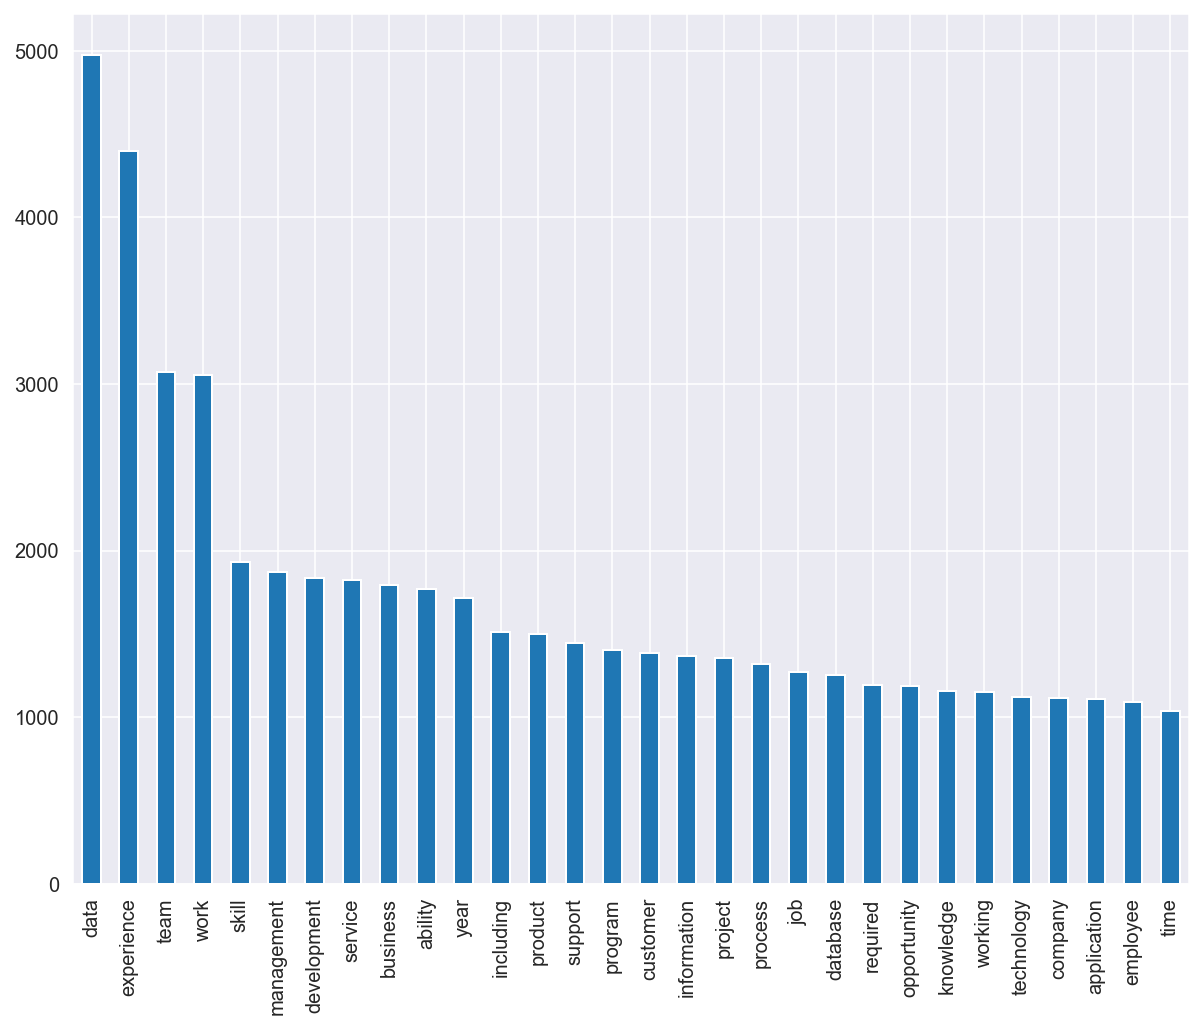

In [104]:
plt.figure(figsize=(10,8))
desctoken_df.sum().sort_values(ascending=False).head(30).plot(kind='bar');

In [65]:
jobs_cv.shape

(813, 8362)

In [67]:
list(cv.vocabulary_.keys())[:10]

['clinical',
 'trial',
 'research',
 'coordinator',
 'ctrc',
 'novice',
 'level',
 'position',
 'direction',
 'principal']

In [30]:
# Instantiate the transformer.
tvec = TfidfVectorizer(stop_words='english', min_df=2)

In [31]:
tvec.fit(jobs_df['token_desc'])

jobs_tvec = tvec.transform(jobs_df['token_desc'])
desctoken_tvec = pd.DataFrame(jobs_tvec.todense(), columns=tvec.get_feature_names())

In [32]:
desctoken_tvec.sum().sort_values(ascending=False).head(50)

data           56.400521
experience     47.740065
team           35.736909
work           32.285233
business       27.340323
product        27.034401
customer       24.928289
development    24.556714
service        24.450338
management     23.087359
skill          22.974549
ability        22.295849
project        20.913692
client         20.601753
year           20.159674
support        19.686360
program        19.408226
clinical       18.955835
technology     18.802915
company        18.525142
technical      18.328319
including      18.239583
information    18.061516
nan            18.000000
required       17.782791
process        17.560652
application    17.433892
job            17.433491
design         17.367714
software       16.949882
database       16.296850
working        16.284045
employee       16.236682
solution       16.085711
knowledge      15.991537
engineering    15.917955
analysis       15.499902
opportunity    15.403616
new            15.188676
health         15.022435


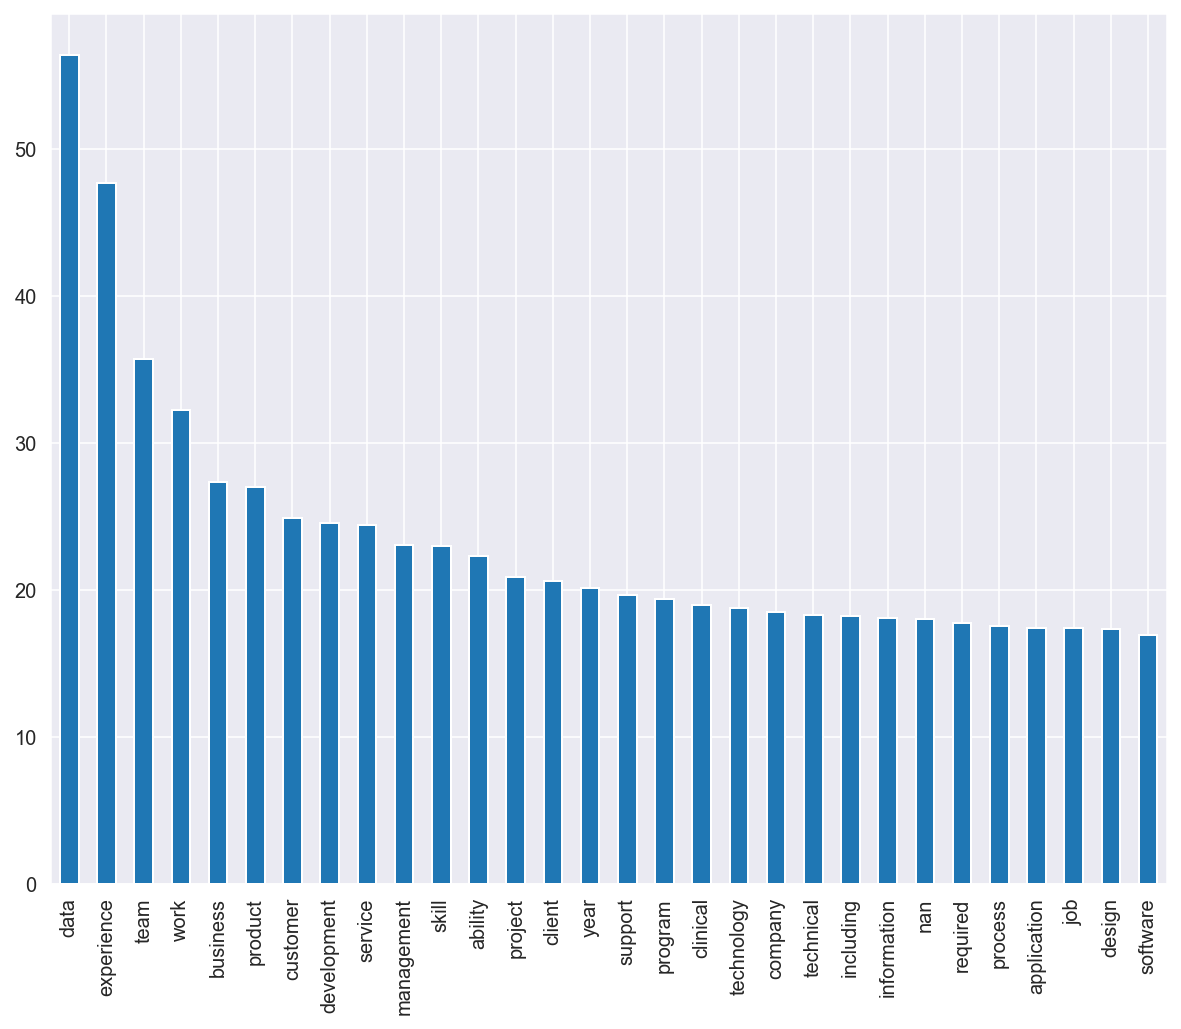

In [33]:
plt.figure(figsize=(10,8))
desctoken_tvec.sum().sort_values(ascending=False).head(30).plot(kind='bar');

In [69]:

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(jobs_cv)

TfidfTransformer()

In [70]:
tfidf_transformer.idf_


array([2.99243016, 2.84214796, 6.315666  , ..., 6.315666  , 6.60334808,
       6.60334808])

In [71]:

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [78]:

feature_names=cv.get_feature_names()

tf_idf_vector=jobs_cv

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top 10
keywords=extract_topn_from_vector(feature_names,sorted_items,20)

for k in keywords:
    print(k,keywords[k])

education 62
member 59
special 55
data 35
publication 48
customer 42
safety 40
development 39
visualization 37
project 35


In [ ]:
#generate tf-idf for all documents in your list.
tf_idf_vector=tfidf_transformer.transform(cv.transform(jobs_df['token_desc']))

results=[]
for i in range(tf_idf_vector.shape[0]):
    
    # get vector for a single document
    curr_vector=tf_idf_vector[i]
    
    #sort the tf-idf vector by descending order of scores
    sorted_items=sort_coo(curr_vector.tocoo())

    #extract only the top 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    
    results.append(keywords)

df=pd.DataFrame(zip(jobs_df['title'],results),columns=['title','keywords'])

In [83]:
df.head(30)

,title,keywords
0,"Clinical Trial Research Coordinator I - South San Francisco,..._new","{'trial': 0.297, 'pi': 0.26, 'clinical': 0.234, 'study': 0.192, 'assist': 0.183, 'research': 0.169, 'participant': 0.158, 'kpnc': 0.153, 'protocol': 0.147, 'licensed': 0.145}"
1,Senior Research Assistant_new,"{'participant': 0.435, 'study': 0.367, 'questionnaire': 0.182, 'permanente': 0.171, 'kaiser': 0.151, 'nue': 0.136, 'consent': 0.125, 'telephone': 0.124, 'status': 0.115, 'required': 0.114}"
2,Data Analyst_new,"{'sale': 0.234, 'analytic': 0.21, 'mortgage': 0.185, 'mi': 0.172, 'comparable': 0.163, 'support': 0.142, 'reporting': 0.141, 'housing': 0.135, 'risk': 0.134, 'presentation': 0.134}"
3,"SR Product Analyst - Chartio, SQL (Part-time Contract/REMOTE..._new","{'cybercoders': 0.286, 'expert': 0.237, 'dashboard': 0.218, 'eligibility': 0.175, 'product': 0.155, 'rebuild': 0.15, 'caroline': 0.15, 'ministry': 0.143, 'developer': 0.14, 'contract': 0.135}"
4,Sr. PHP Developer_new,"{'roi': 0.277, 'debt': 0.248, 'php': 0.232, 'search': 0.182, 'able': 0.172, 'existing': 0.168, 'product': 0.137, 'cloud': 0.124, 'software': 0.119, 'coding': 0.109}"
5,Outcomes Manager_new,"{'contained': 0.287, 'hospital': 0.276, 'patient': 0.243, 'interdisciplinary': 0.239, 'reported': 0.22, 'documentation': 0.218, 'outcome': 0.211, 'coordination': 0.153, 'care': 0.152, 'unrestricted': 0.143}"
6,Senior Estimator ( College Construction Environment )_new,"{'cost': 0.429, 'estimate': 0.393, 'estimating': 0.351, 'construction': 0.349, '10': 0.194, 'preferred': 0.15, 'contractor': 0.127, 'scope': 0.125, 'contracting': 0.12, 'order': 0.119}"
7,"Associate Director, Category Management_new","{'category': 0.253, 'brand': 0.178, 'like': 0.172, 'work': 0.144, 'premier': 0.144, 'don': 0.132, 'emeryville': 0.132, 'nutrition': 0.129, 'sale': 0.128, 'casual': 0.119}"
8,10100 AEM Quality Assurance Program Lead_new,"{'test': 0.309, 'defect': 0.227, 'cm': 0.222, 'assurance': 0.21, 'testing': 0.201, 'qa': 0.16, 'quality': 0.145, 'selenium': 0.142, 'marketing': 0.141, 'customer': 0.141}"
9,Data and Information Manager_new,"{'provost': 0.569, 'faculty': 0.206, 'academic': 0.183, 'report': 0.161, 'position': 0.156, 'office': 0.136, 'adjunct': 0.127, 'manage': 0.117, 'relocation': 0.103, 'functioning': 0.103}"
